In [23]:
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import random
import cv2
import shutil


In [25]:
setup_logger()
dataset_dir = "dataset/"
train_dir = dataset_dir + "train"
val_dir = dataset_dir + "val"
test_dir = dataset_dir + "test"
classes = ["red", "pink", "yellow", "blue", "orange", "green"]
camera_rows = 516
camera_cols = 656

In [2]:
# allFileNames = np.arange(50)
# np.random.shuffle(allFileNames)
# train_ratio = 0.8
# is_new = False

# if not os.path.isdir(dataset_dir +'train/'):
#     os.makedirs(dataset_dir +'train/')
#     is_new = True
# if not os.path.isdir(dataset_dir +'val/'):
#     os.makedirs(dataset_dir +'val/')
#     is_new = True

# if is_new:
#     train_FileNames, val_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)* train_ratio)])
#     for name in train_FileNames:
#         shutil.copy(dataset_dir+"test_"+str(name)+".jpg", "dataset/train")
#         shutil.copy(dataset_dir+"test_"+str(name)+".json", "dataset/train")

#     for name in val_FileNames:
#         shutil.copy(dataset_dir+"test_"+str(name)+".jpg", "dataset/val")
#         shutil.copy(dataset_dir+"test_"+str(name)+".json", "dataset/val")


In [3]:
def get_data(img_dir):
    dataset_dicts = []
    for filename in [file for file in os.listdir(img_dir) if file.endswith('.json')]:
        json_file = os.path.join(img_dir, filename)
        with open(json_file) as f:
            img_label = json.load(f)

        record = {}
        
        img = os.path.join(img_dir, img_label["imagePath"])
        
        record["file_name"] = img
        record["height"] = camera_rows
        record["width"] = camera_cols
      
        shapes = img_label["shapes"]
        objs = []
        for shape in shapes:
            px = [a[0] for a in shape['points']]
            py = [a[1] for a in shape['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(shape['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [4]:
for d in ["train", "val", "test"]:
    DatasetCatalog.register(d, lambda d=d: get_data("dataset/" + d))
    MetadataCatalog.get(d).set(thing_classes=classes)

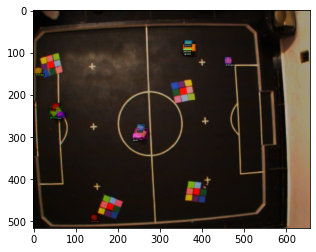

In [20]:
dataset_dicts = get_data(train_dir)
train_metadata = MetadataCatalog.get("train")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[..., ::-1][..., ::-1])

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.RANDOM_FLIP = "horizontal"
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1200
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.STEPS = []   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 118 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes) 


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 

predictor = DefaultPredictor(cfg)

In [21]:
i = 0
for d in [file for file in os.listdir(val_dir) if not file.endswith('.json')]:    
    im = cv2.imread(val_dir +"/"+ d)
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("val_" + str(i) + ".jpg", out.get_image()[..., ::-1])
    i += 1

In [26]:
i = 0
for d in os.listdir(test_dir):    
    im = cv2.imread(test_dir + "/" + d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite("test_" + str(i) + ".jpg", out.get_image()[..., ::-1])
    i += 1

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)